# Group members:
Fabio Ceruti

Fabio Martino

Valerio Di Palo

Jacopo Biggiogera

## 1. Research Questions

In our project we are analysing the speeches made by italian parliamentarians at the italian parliament. The overall aim of our project is to generate a suite of NLP tools that can be used to aid social and political scientists with research on italian politics. With teh scarcity of NLP models that go beyond just the english language the need for such tools if of increasing importance. As such our research questions are:

1. Are there semantic differences in the way parliamentaries from different parties and political background speak?

2. Can we exploit such differences and similarities to build a classifier that can effectively predict which party a politician belongs to by using what they said and a few demographic qualities?

3. Can we build an effective POS tagger that is specialised on italian political language ?

## 2. Data Preprocessing

The dataset consist of 17992 documents and was sourced from:
https://www.clarin.eu/resource-families/parliamentary-corpora

Each document is an intervention given by a parliamentary during a seating of the italina parliament between the years 2018 and 2020. As such for each  document we have:
1. what the parliemantary said and the POS tags for each token 
2. the year in which they spoke
3. the party they belong to and whether it is part of the opposition or of the governing coalition.
4. Name, gender and year of birth of the speaker

As such we will be using the **same** dataset for both classification and structured prediction tasks.
In this first section of Exploratory analysis we will try and address the first research question outlined previosuly.

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

...

In [10]:
#Downloading italian spacy
#!python -m spacy download it_core_news_sm

In [1]:
#Importing modules
import spacy
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases
import pandas as pd
import sys 
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
output_stream = sys.stdout

In [2]:
nlp = spacy.load('it_core_news_sm', disable=['ner', 'textcat']) 

def text_cleaning_lemma(text):
     return ' '.join([token.lemma_ for token in nlp(text[:len(text)//2]) if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'} and
             token not in set(stopwords.words('italian'))]) 

In [73]:
# Here we read in the data from the Data extraction file (uncomment if want too start running from here)
#df=pd.read_csv('ita_par_data.csv')

In [47]:
#Before preprocessing: Extracting each single word before preprocessing
words = defaultdict(lambda: 0)
dc = []
for doc in tqdm(df['words'].tolist()):
    d = []
    if type(doc) is str:
        for token in doc.split():
            d.append(token)
            words[token] +=1
        dc.append(d)

100%|███████████████████████████████████| 17922/17922 [00:08<00:00, 2190.64it/s]



Summary Statistics (BEFORE PREPROCESSING):

Number of documents: 17922
Average words per document: 511.513
Number of types: 95718
Number of tokens: 9167337
Top 5 most used words: ['di', ',', 'il', '.', 'la']



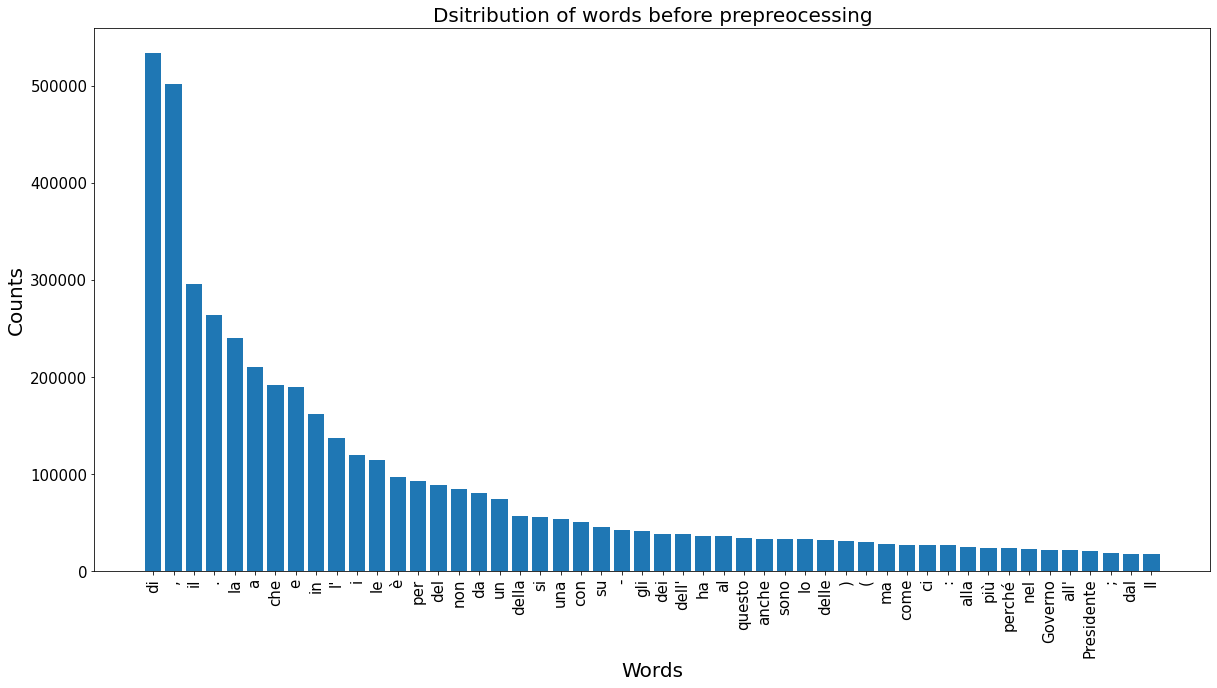

In [71]:
#Statistics before preprocessing:
sort_list_words = [k for k, v in sorted(words.items(), key=lambda item: item[1], reverse = True)]
sort_counts = [v for k, v in sorted(words.items(), key=lambda item: item[1], reverse = True)]
n_docs = df.shape[0]
avg_wordsperdoc = sum([len(i) for i in dc])/df.shape[0]
n_types = len(words.keys())
n_tokens = sum(words.values())
top5_w = sort_list_words[:5]
print(f'''
Summary Statistics (BEFORE PREPROCESSING):

Number of documents: {n_docs}
Average words per document: {round(avg_wordsperdoc, 3)}
Number of types: {n_types}
Number of tokens: {n_tokens}
Top 5 most used words: {top5_w}
''')

#Plotting the distribution (only first 50 words shown for readibility)

plt.rcParams['figure.figsize'] = [20 , 10]
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.bar(sort_list_words[:50], sort_counts[:50])
plt.xticks(rotation = 90)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Dsitribution of words before prepreocessing')
plt.show()

As we can see we have many non content words such as articles like **di** and **il** that dominate the distribution. We thus now proceed with the cleaning.

In [4]:
#df=df[df['text'].isna()==False]
df['text'] = df['text'].astype(str)

In [5]:
lem=[]
for j in range(len(df.text)):
    if df.text[j]!='nan':
        lem.append(text_cleaning_lemma(df.text[j]))
        output_stream.write('Cleaning %s\r' % j)
        output_stream.flush()
    else:
        lem.append(None)

In [6]:
#Substituting all numbers with 0s. This should lead to greater comparability of text between dscourses as numbers per se will 
#not have special meaning in the corpus.
for j in range(len(lem)):
    if lem[j]!=None:
        tx = re.sub(r'\d', '0', lem[j])
        lem[j]=tx.lower()
        output_stream.write('Discourses changed %s\r' % j)
        output_stream.flush()

#Joining collocations. Once again, this should improve the comparability of discourses as words that form one construct will 
#be joined together.

In [7]:
for j in range(len(lem)):
    if lem[j]!=None:
        words = lem[j].split()
        phrases = Phrases(words)
        collocations = phrases[words]
        lem[j]=' '.join(collocations)
        output_stream.write('Collocation %s\r' % j)
        output_stream.flush()

In [8]:
df['lemmatized']=lem

In [10]:
df2 = df.drop(['Unnamed: 0','ID', 'Title', 'From', 'To', 'House',
       'Term', 'Session', 'Meeting', 'Sitting', 'Agenda', 'Subcorpus'], axis = 1)
df2.dropna(inplace = True)
df2.reset_index(inplace = True)
df2 = df2.iloc[:, 1:]

In [74]:
#Saving cleaned and preprocessed data
#df.to_csv('cleaned_nonans.csv')

As part of this preprocessing we have done a series of steps:
1. removed stop words, numbers and non content words
2. lemmatized words
3. added collocations

These measures should allows us to reduce the variance amongst the tokens and better highlight the semantic content present within the corpus.

In [2]:
#Here we reimport the cleaned data to avoid having to rerun the cleaning every time
df=pd.read_csv('cleaned_nonans.csv')

As a large amount of our analysis will focus on the party of origin of the parliamentary who is speaking. Thus, before actually proceeding with the analysis we begin by exploring the distribution of parties present in the dataset.

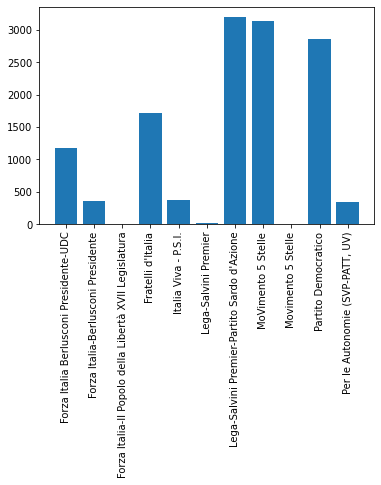

In [3]:
#Plotting party distributions
arr = np.array(df['Speaker_party_name'])
labels, counts = np.unique(arr, return_counts = True)
plt.bar(labels, counts, align = 'center')
plt.xticks(rotation = 90)
plt.show()

As we can see there are in total 11 parties. However, we notice that some parties are different because of a spelling mistake (**Movimento5stelle** vs **MoVimento5stelle**), some are just subgroups divisions of the same party (ex. **Lega- Salvini Premier** and **Lega-Salvini Premier-Partito sardo d'Azione** are both actually form **Lega**) and others have so little observations that including them in the analyses and in the classification task could very well add more noise and excessive variability that would not allow to find robust results (ex. **Italia Viva** and **Per le Autonomie**).
We thus decided to:
1. merge subgroups of parties that actuallly belong to the same macro party
2. drop parties for which the number of observations are too small to effectively carry out analyses (like classification)

We now implement this cleaning:

In [4]:
clean_names = []
for i in df['Speaker_party_name'].tolist():
    if (i == 'Forza Italia Berlusconi Presidente-UDC') | (i == 'Forza Italia-Berlusconi Presidente') | (i == 'Forza Italia-Il Popolo della Libertà XVII Legislatura'):
        clean_names.append('Forza Italia')
    elif (i == 'Lega-Salvini Premier') | (i == "Lega-Salvini Premier-Partito Sardo d'Azione"):
        clean_names.append('Lega')
    elif i == 'MoVimento 5 Stelle':
        clean_names.append('Movimento 5 Stelle')
    else:
        clean_names.append(i)
df['Party_name_red'] = clean_names

In [5]:
df=df[(df['Party_name_red']!='Per le Autonomie (SVP-PATT, UV)') & (df['Party_name_red']!='Italia Viva - P.S.I.')]

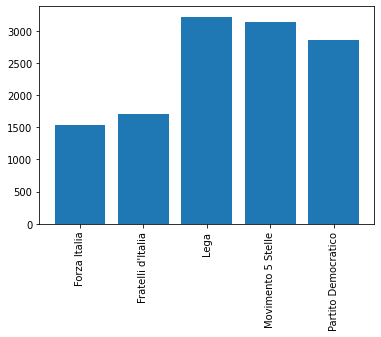

In [6]:
#Plotting party distributions
arr = np.array(df['Party_name_red'])
labels, counts = np.unique(arr, return_counts = True)
plt.bar(labels, counts, align = 'center')
plt.xticks(rotation = 90)
plt.show()

We are thus left with five major parties (who also are the five biggest parties in the italian parliament) as we can see from the bar char above. These are:
1. Forza Italia (Centre-Right wing)
2. Fratelli d'Italia (Centre-Right wing)
3. Lega (Centre-Right wing)
4. Movimento 5 Stelle (Centre-Left wing)
5. Partitio Democratico (Centre-Left wing)

In [7]:
wordsc = defaultdict(lambda: 0)
dclean = []
for doc in tqdm(df['lemmatized'].tolist()):
    d = []
    if type(doc) is str:
        for token in doc.split():
            d.append(token)
            wordsc[token] +=1
        dclean.append(d)

100%|██████████████████████████████████| 12454/12454 [00:00<00:00, 19978.54it/s]



Summary Statistics (BEFORE PREPROCESSING):

Number of documents: 12454
Average words per document: 102.781
Number of types: 32076
Number of tokens: 1280037
Top 5 most used words: ['non', 'fare', 'dell', 'presidente', 'anche']



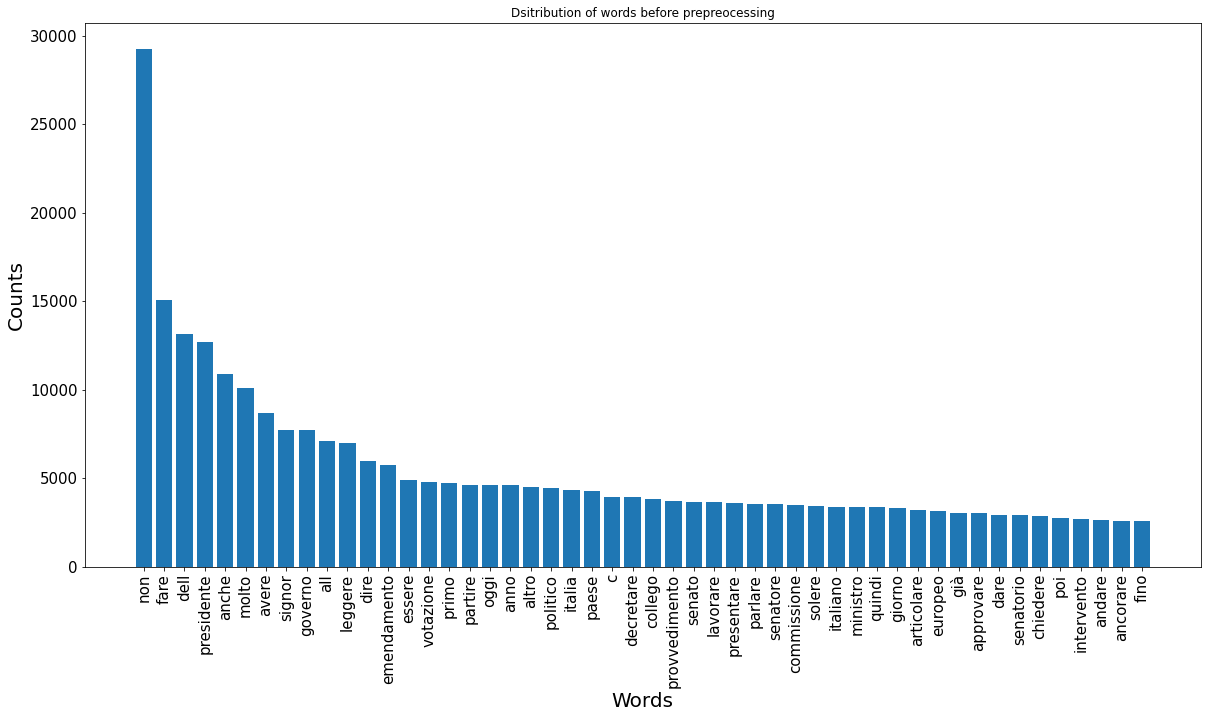

In [8]:
#Statistics after preprocessing:
sort_list_wordsc = [k for k, v in sorted(wordsc.items(), key=lambda item: item[1], reverse = True)]
sort_countsc = [v for k, v in sorted(wordsc.items(), key=lambda item: item[1], reverse = True)]
n_docsc = df.shape[0]
avg_wordsperdocc = sum([len(i) for i in dclean])/df.shape[0]
n_typesc = len(wordsc.keys())
n_tokensc = sum(wordsc.values())
top5_wc = sort_list_wordsc[:5]
print(f'''
Summary Statistics (BEFORE PREPROCESSING):

Number of documents: {n_docsc}
Average words per document: {round(avg_wordsperdocc, 3)}
Number of types: {n_typesc}
Number of tokens: {n_tokensc}
Top 5 most used words: {top5_wc}
''')

#Plotting the distribution (only first 50 words shown for readibility)

plt.rcParams['figure.figsize'] = [20 , 10]
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.bar(sort_list_wordsc[:50], sort_countsc[:50])
plt.xticks(rotation = 90)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Dsitribution of words before prepreocessing')
plt.show()

We can see that the preprocseeing was indeed succesfull and allowed to significantly reduce not only the amount of types, but also changed the distribution to put more emphasis on words like **presidente** and **governo**

# 3.EXPLORATORY ANALYSIS

In [9]:
import spacy
import pandas as pd 
import nltk 
from nltk.collocations import *
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
import pickle
import numpy as np 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings

## 3.1 Implementing Word2Vec

In [11]:
sentences = [str(line).split() for line in df['lemmatized']]
cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=15,
                     window=7,
                     vector_size=300,
                     sample=6e-6, #moved down to get better similiarities,
                     alpha=0.03, 
                     min_alpha=0.0010, 
                     negative=20,
                     workers=cores-1)

w2v_model.build_vocab(sentences, progress_per=10000)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(6466073, 38401110)

In [12]:
w2v_model.wv.most_similar('lega')

[('partito', 0.9652660489082336),
 ('imbarazzare', 0.9443804025650024),
 ('fraccaro', 0.9425051808357239),
 ('centrodestra', 0.9315248727798462),
 ('premier', 0.9271077513694763),
 ('liberi', 0.9225499629974365),
 ('casaleggio', 0.9142359495162964),
 ('spiegare', 0.9137037396430969),
 ('capisco', 0.9134434461593628),
 ('rivolgendomi', 0.9096558094024658)]

In [13]:
w2v_model.wv.most_similar('salvini')

[('viminale', 0.9039477705955505),
 ('matteo', 0.8885021805763245),
 ('bonafede', 0.8850878477096558),
 ('tweet', 0.8820933699607849),
 ('dimettere', 0.8628717660903931),
 ('mandare', 0.8575635552406311),
 ('accusa', 0.8546918630599976),
 ('accusare', 0.85152667760849),
 ('maduro', 0.8478887677192688),
 ('ministrare', 0.8454840779304504)]

In [14]:
w2v_model.wv.similarity('salvini', 'berlusconi')

0.810063

It is possible to notice that the party **lega** is indeed closer to words that are both related to the centre -right and to the political exponents of the oppositino (ex **renzi**). In addition we can see a high similarity between **salvini** and **berlusconi**, which is expected as they are two leaders of two of the biggest centr-right wing parties. Indeed, this not only points at the fact that the word2vec tuning has been succesful but also points at important resulst discussed after the visualisation.

### TSNE visualization

In [15]:
def display_closestwords_tsnescatterplot(model, word,n, palette='viridis_r'):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.most_similar([word], topn = n)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords, c=np.arange(0,len(close_words)+1), cmap=palette)#, cmap=cMap)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-50, x_coords.max()+150)
    plt.ylim(y_coords.min()-50, y_coords.max()+50)
    plt.title('MOST SIMILAR WORDS TO {}'.format(word))
    plt.show()

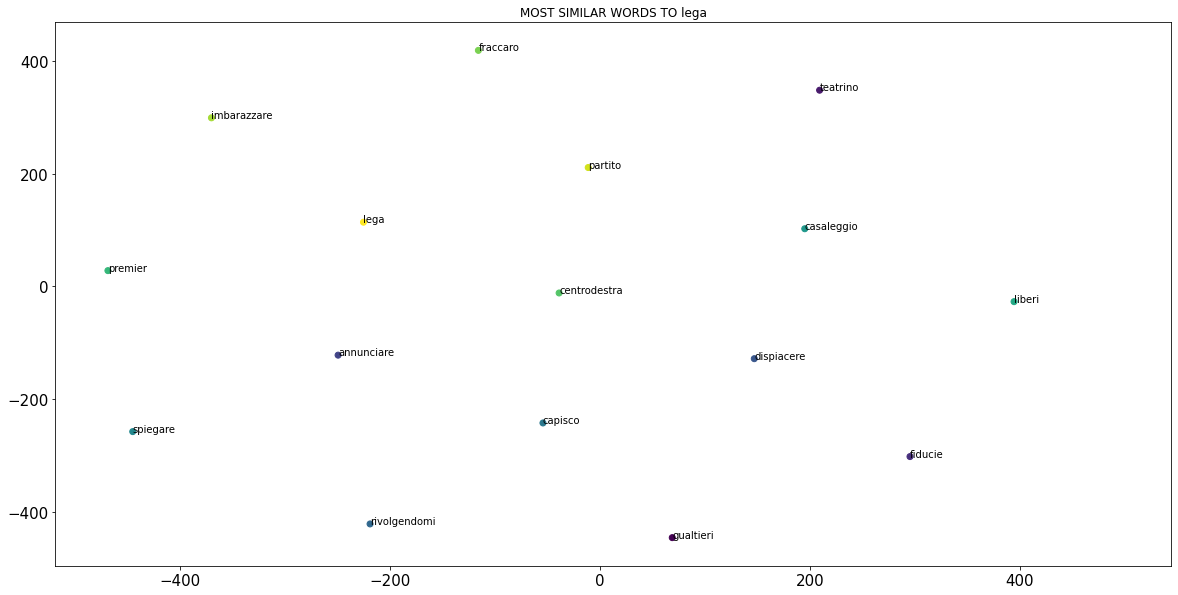

In [21]:
warnings.filterwarnings('ignore')
display_closestwords_tsnescatterplot(w2v_model,'lega',15)

Is possible to notice that trough the usage of Word2Vec we are able to capture some of the nuances in the political parties and its main political characters. As an example we can see that in the most similiar words to 'lega' we are able to not only find word like **centrodestra** and **partito**, which define characteristics of this party, but also words like **teatrino** and **renzi** that might have been used by members of this party to talk about their opposing parties. Indeed, this analysis highlights the presence of certain word relationship with parties and with specific politicians. It points at a 'double edged' importance both of words that specific politicians use to refer to their party, but also at the importance that opposing parties might use to describe each other's parties. Indeed, such results further motivate the creation of NLP tools that are specifically trained on political corpuses form teh country of interest.

## 3.2 Generating Document embeddings

In [8]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
np.random.seed(4)
#Adding unique entry for each document for subsequent Doc2Vec Embedding
df['id'] = range(df.shape[0])

# create a list of TaggedDocument objects
corpus = []

for row in df.iterrows(): 
    label = row[1].id
    text = row[1].lemmatized
    corpus.append(TaggedDocument(words=text.split(), 
                                 tags=[str(label)]))

print('done')
# initialize model
d2v_model = Doc2Vec(vector_size=300, 
                    window=15,
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1)

# build the vocabulary
d2v_model.build_vocab(corpus)

# train the model
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

done


### Dimensionality reduction with  t-SNE

In [12]:
dvec = d2v_model.dv.vectors
from sklearn.manifold import TSNE
warnings.filterwarnings('ignore')
U = TSNE(n_components=2,
                 random_state = 4).fit_transform(dvec)

In [79]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    dfr = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1], 
                            'word': list(df.Party_name_red)[:len(vectors)] })
    # add labels, if supplied
    if labels is not None:
        dfr['label'] = labels
    else:
        dfr['label'] = [''] * len(dfr)

    # assign colors to labels
    cm = plt.get_cmap('hsv') # choose the color palette
    n_labels = len(dfr.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        dfr['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(dfr.label.unique()):
            df2 = dfr[dfr.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(dfr.label.unique()):
            df2 = dfr[dfr.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.15, 
                       s=100)

    else:
        raise NotImplementedError()

    for i in range(20):
        i = np.random.randint(0,1000) 
        plt.text(dfr['x'][i], dfr['y'][i], dfr['word'][i])
    plt.title(title)
    #plt.legend(labels = legend)
    plt.show()

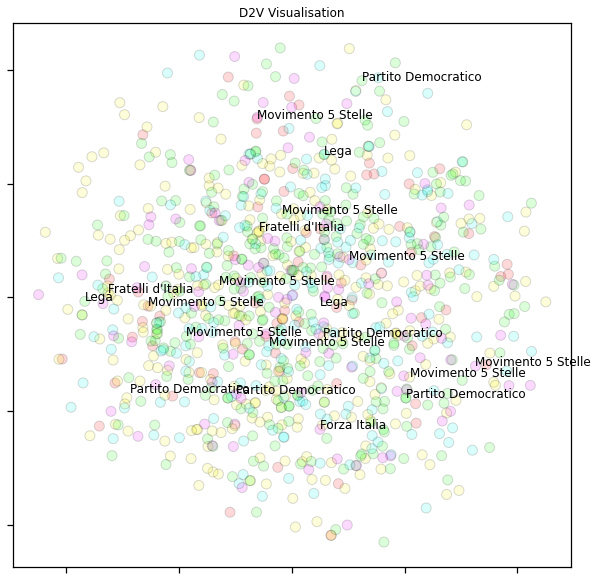

In [80]:
np.random.seed(15)
plot_vectors(U[0:1000], title = 'D2V Visualisation', labels = df.Party_name_red[0:1000], dimensions = 2)

As an initial visualisation we plotted the Doc2Vec visualisations without clustering. This was to see if there were some naturally emerging clusters before any sort of clustering procedure. It became clear that this was not the case.

100%|██████████| 7/7 [00:49<00:00,  7.11s/it]


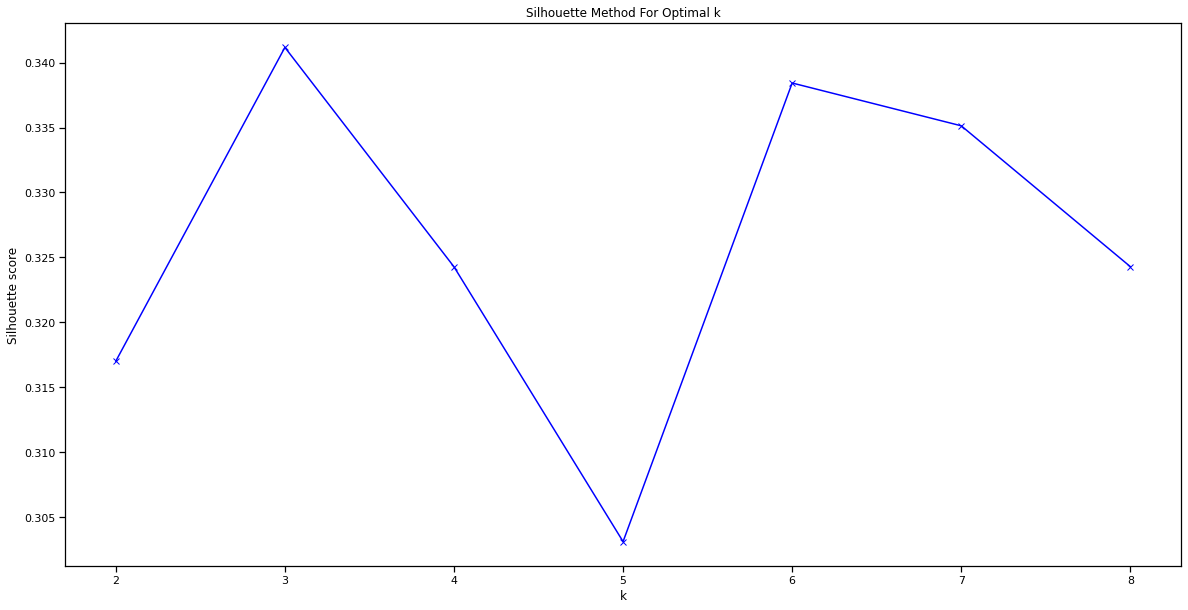

In [81]:
#Silhouette scoring to find the best number of clusters to utilise
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tqdm import tqdm

silhouettes = []
K = range(2, 9)
for c in tqdm(K):
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(U)
    agg_centroids = np.array([U[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) 
                            for k in range(c)])

    kmeans_clustering = KMeans(n_clusters=c, init = agg_centroids, n_init = 1)
    kmeans_ids = kmeans_clustering.fit_predict(U)
    score = silhouette_score(U, kmeans_ids)
    silhouettes.append(score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [82]:
k = 3
ids = AgglomerativeClustering(n_clusters=k).fit_predict(U)

centroids = np.array([U[ids == c].mean(axis=0) for c in range(k)])

km = KMeans(n_clusters=k, 
           init = centroids, 
           n_init = 1)
km.fit(U)

KMeans(init=array([[  8.098582,  13.317132],
       [-18.343922,  -5.98147 ],
       [ 12.161068, -20.334108]], dtype=float32),
       n_clusters=3, n_init=1)

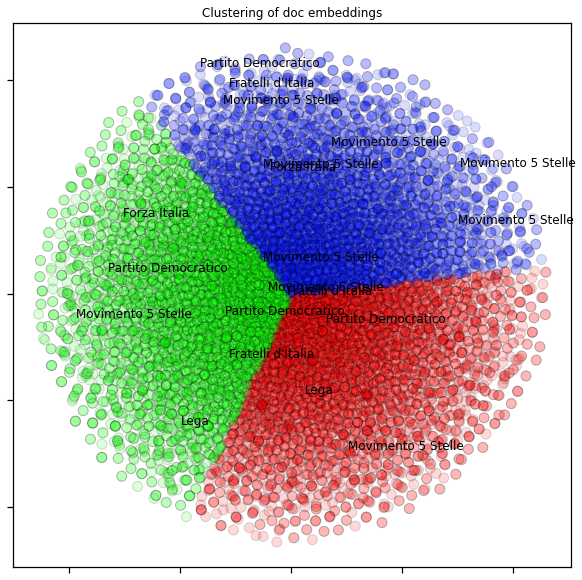

In [83]:
#Visualising the clusters of the doc2vecs of each speaker and labelling by the party of the speaker
np.random.seed(9)
plot_vectors(U, title = 'Clustering of doc embeddings', labels=km.labels_, dimensions = 2)

Indeed while we can see that there are three defined clusters they seem to be quite close in space to one another and with a considerable mixing of members from various parties. Before reaching specific conclusions we thus decided to try and implement document level embeddings using a more powerful state of the art model:BERT.

### Implementing BERT to test relationships with new document embeddings

In [13]:
from sentence_transformers import SentenceTransformer
np.random.seed(4)
model_bert = SentenceTransformer('bert-base-nli-max-tokens')
embedding_bert = np.array(model_bert.encode(corpus, show_progress_bar = True))

Batches:   0%|          | 0/390 [00:00<?, ?it/s]

In [14]:
UBERT = TSNE(n_components=2,
                 random_state = 4).fit_transform(embedding_bert)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


100%|██████████| 7/7 [00:42<00:00,  6.10s/it]


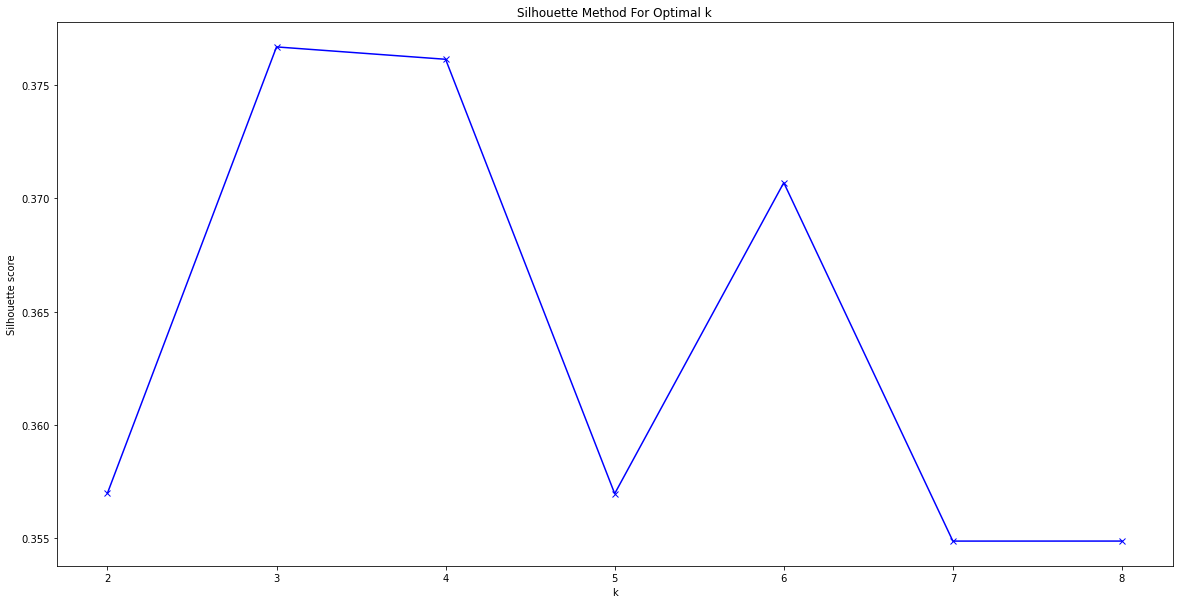

In [15]:
#Silhouette scoring to find the best number of clusters to utilise
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tqdm import tqdm

silhouettes = []
K = range(2, 9)
for c in tqdm(K):
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(UBERT)
    agg_centroids = np.array([UBERT[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) 
                            for k in range(c)])

    kmeans_clustering = KMeans(n_clusters=c, init = agg_centroids, n_init = 1)
    kmeans_ids = kmeans_clustering.fit_predict(UBERT)
    score = silhouette_score(UBERT, kmeans_ids)
    silhouettes.append(score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [16]:
k = 3
ids1 = AgglomerativeClustering(n_clusters=k).fit_predict(UBERT)

centroids1 = np.array([UBERT[ids1 == c].mean(axis=0) for c in range(k)])

km1 = KMeans(n_clusters=k, 
           init = centroids1, 
           n_init = 1)
km1.fit(UBERT)

KMeans(init=array([[-26.221777 ,  21.802896 ],
       [ 47.01744  ,   0.8696908],
       [-10.082704 , -44.379936 ]], dtype=float32),
       n_clusters=3, n_init=1)

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors2(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    dfr = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1], 
                            'word': list(df.Party_name_red)[:len(vectors)] })
    # add labels, if supplied
    if labels is not None:
        dfr['label'] = labels
    else:
        dfr['label'] = [''] * len(dfr)

    # assign colors to labels
    cm = plt.get_cmap('hsv') # choose the color palette
    n_labels = len(dfr.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        dfr['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(dfr.label.unique()):
            df2 = dfr[dfr.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(dfr.label.unique()):
            df2 = dfr[dfr.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.15, 
                       s=100)

    else:
        raise NotImplementedError()
    
    if labels is not None:
        dft = dfr.groupby(['label', 'word']).count()
        dftest = dft.iloc[:, 1].reset_index().iloc[:, 1:]
        g1 = dftest.iloc[0:5, :].sort_values(by = 'y',ascending = False)
        g2 = dftest.iloc[5:10, :].sort_values(by = 'y',ascending = False)
        g3 = dftest.iloc[10:, :].sort_values(by = 'y',ascending = False)
        name1 = f'''
        Dominant in cluster:
        {g1.iloc[0, 0]}: {g1.iloc[0, 1]} 
        {g1.iloc[1, 0]}: {g1.iloc[1, 1]}
        '''
        
        name2 = f'''
        Dominant in cluster:
        {g2.iloc[0, 0]}: {g2.iloc[0, 1]} 
        {g2.iloc[1, 0]}: {g2.iloc[1, 1]}
        '''
        
        name3 = f'''
        Dominant in cluster:
        {g3.iloc[0, 0]}: {g3.iloc[0, 1]} 
        {g3.iloc[1, 0]}: {g3.iloc[1, 1]}
        '''
        
        plt.text(-100,10, name1, bbox=dict(facecolor=label_colors[0], alpha=0.5))
        plt.text(10,10, name2, bbox=dict(facecolor=label_colors[1], alpha=0.5))
        plt.text(-90,-90, name3, bbox=dict(facecolor=label_colors[2], alpha=0.5))
        
    #for i in range(20):
        #i = np.random.randint(0,1000) 
        #plt.text(dfr['x'][i], dfr['y'][i], dfr['word'][i])
    plt.title(title)
    #plt.legend(labels = legend)
    plt.show()

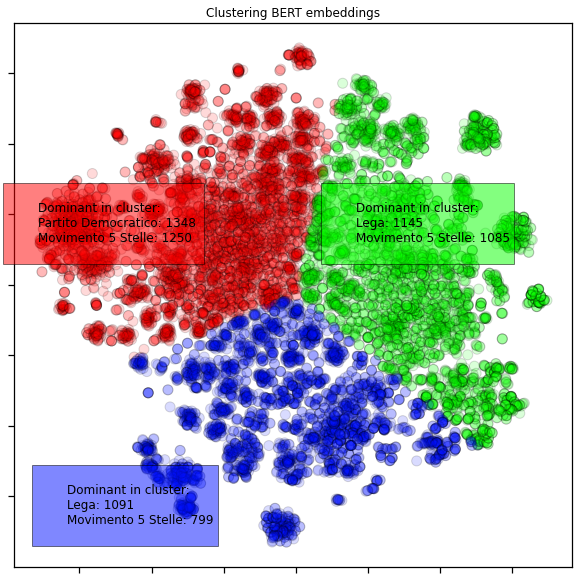

In [18]:
#Taking a sample of the data to make it easier to visualise
plot_vectors2(UBERT, title = 'Clustering BERT embeddings', labels=km1.labels_, dimensions = 2)

Although very similar in broad terms to the non BERT embeddings, this clustering is more subtle in highlighting a greter division between the three clusters. Indeed, these seem to be further away and have greater 'portions' of data points that are at further extremes from one another between the clusters. When we also include the most common parties ebtween each clusters we can see changing patterns. Indeed, different pairs of parties seem to be most common toegther in each cluster. This is an interesting result since, although the clusters are indeed still pretty close (something that is still consistent in a political context that is likely to present some semantic similarities in terms of the broad topics discussed, regardless of the party), it points at some potential differences in semantic contents that are present between parties. This is something that we will further explore thorugh topic models, but is already salient for frmaing the classification task presented in the Classification notebook.

## 3.3 Topic Modelling

To get a sense of the main topics which take place in the italian Parlamient, we decided to inspect its members interventions. Even though, we are aware that LDA might yield less meaningfull results than autor model, we prefered to get first a general impression of what were the main arguments of these sessions, and later move on the author model.

### Latent Dirilechlet Allocation


In [15]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

import re
import tqdm
import time 
import multiprocessing
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 7, 'font.style': 'normal', 'font.family':'serif'})

In [16]:
corpus2 = df.lemmatized

clean_cp = pd.Series(corpus2)
instances = clean_cp.apply(str.split).tolist()
#creating a dictionary of the words based on their frequencies
phrases = Phrases(instances, min_count=5,threshold=1)
collocations = phrases[instances]
dictionary = Dictionary(collocations)
#take out too rare or too frequent words
dictionary.filter_extremes(no_below=10, no_above=0.25)
#I then used gensim to transform the corpus into a TFIDF-weighted matrix
ldacorpus = [dictionary.doc2bow(word) for word in instances]

model = TfidfModel(ldacorpus)
model_corpus = model[ldacorpus]

In order to choose the number of topics we used both the umass score and the choerence one.

In [17]:
coherence_scores = []
start = time.time()
for n_topics in range(3,25):
    
    model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary, 
                         num_topics=n_topics, random_state=6)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    print(n_topics, umass_score, cv_score)
    coherence_scores.append((n_topics, umass_score, cv_score))
print(f"Done in {time.time()-start}")

3 -2.4058552057530203 0.4455786828472001
4 -1.9068382315114554 0.42923785368075096
5 -2.472831902778131 0.3870822580164103
6 -2.4507770313410235 0.3825094438621725
7 -2.3426146642992642 0.3928181058604728
8 -2.18899003040664 0.3755850037314408
9 -2.242138585254846 0.39030880491604025
10 -2.5271918104182105 0.38638072362345294
11 -2.2661572042675964 0.3780734489262601
12 -2.3090369712659977 0.38807389718182245
13 -2.2861179492738257 0.3962850477814809
14 -2.2301304185198556 0.40312250485729006
15 -2.2274458369575076 0.39794875922709544
16 -2.1966599438260577 0.41668937687503244
17 -2.4414390414650207 0.37107660384554886
18 -2.275463125173435 0.3856753724650496
19 -2.5718862348722658 0.3729928647821346
20 -2.6566262230190354 0.34733484246006496
21 -2.337659667318478 0.3698869884100035
22 -2.4694311612385706 0.37031270399212307
23 -2.6430847803445996 0.38735182707648663
24 -2.5372764881133194 0.3909883773958858
Done in 623.7828478813171


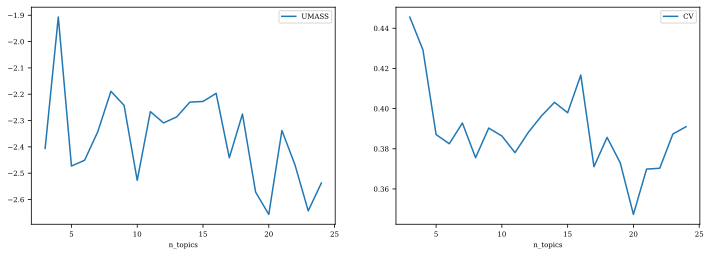

In [18]:
figs,axs= plt.subplots(1,2,figsize=(12,4))
scores = pd.DataFrame(data=coherence_scores, columns=['n_topics','umass_score','cv_score'])

ax = axs[0]
x = np.array(scores.n_topics)
ax.plot(x,scores.umass_score,label='UMASS')
ax.set_xlabel('n_topics')
ax.legend()
ax = axs[1]
ax.plot(x,scores.cv_score,label='CV')
ax.set_xlabel('n_topics')
ax.legend()

plt.legend()
plt.show()

By plotting the measures of the scores we spot a local minimum in the UMASS score and a local maximum in the CV score at 9 topics.

In [19]:
num_topics = 9

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, 
                     corpus=model_corpus, 
                     id2word=dictionary, 
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes, 
                     chunksize=chunk_size, 
                     alpha=0.5,
                     eta =0.2,
                     random_state=43
                    )
    
print("done in {}".format(time.time()-start), flush=True)

622.7
fitting model
done in 95.49830508232117


In [20]:
topic_corpus = model[model_corpus]
model.print_topics()

[(0,
  '0.004*"molto" + 0.003*"dire" + 0.003*"avere" + 0.003*"governo" + 0.002*"essere" + 0.002*"paese" + 0.002*"italia" + 0.002*"oggi" + 0.002*"europeo" + 0.002*"politico"'),
 (1,
  '0.009*"donna" + 0.005*"violenza" + 0.005*"vittima" + 0.004*"ricordare" + 0.004*"morto" + 0.003*"provincia" + 0.003*"città" + 0.003*"unire" + 0.003*"polizia" + 0.003*"solidarietà"'),
 (2,
  '0.017*"lavoro" + 0.015*"il" + 0.014*"a" + 0.011*"conferenza" + 0.010*"leggere" + 0.009*"capigruppo" + 0.009*"calendario" + 0.009*"n." + 0.008*"disegnare" + 0.008*"colleghi"'),
 (3,
  '0.026*"recere" + 0.022*"ordine" + 0.019*"giorno" + 0.019*"ministro" + 0.014*"rispondere" + 0.014*"svolgimento" + 0.011*"immediato" + 0.011*"bis" + 0.009*"signore" + 0.007*"time"'),
 (4,
  '0.033*"votazione" + 0.031*"parere" + 0.029*"emendamento" + 0.026*"esprimere" + 0.019*"indìco" + 0.019*"nominale" + 0.018*"scrutinio" + 0.018*"senatore" + 0.018*"simultaneo" + 0.017*"presentare"'),
 (5,
  '0.029*"discussione" + 0.026*"intervenire" + 0.02

In [21]:
# get the topic descriptions
topic_sep = re.compile("0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))
descriptors

1 "molto", "dire", "avere", "governo", "essere"
2 "donna", "violenza", "vittima", "ricordare", "morto"
3 "lavoro", "il", "a", "conferenza", "leggere"
4 "recere", "ordine", "giorno", "ministro", "rispondere"
5 "votazione", "parere", "emendamento", "esprimere", "indìco"
6 "discussione", "intervenire", "generale", "iscrivere", "comunico"
7 "signor", "presidente", "chiuso", "discussione", "sull"
8 "interrogazione", "sedere", "presidenza", "pervenire", "facoltà"
9 "lettura", "processare", "aprire", "dare", "verbale"


['molto, dire',
 'donna, violenza',
 'lavoro, il',
 'recere, ordine',
 'votazione, parere',
 'discussione, intervenire',
 'signor, presidente',
 'interrogazione, sedere',
 'lettura, processare']

In [22]:
target_category = 'Party_name_red'

# get a list with the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(instances))]

# turn that into a data frame with N rows and K columns, 
# each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)

# add the review category of each document as column (so we can aggregate)
topic_distros['category'] = df[target_category]

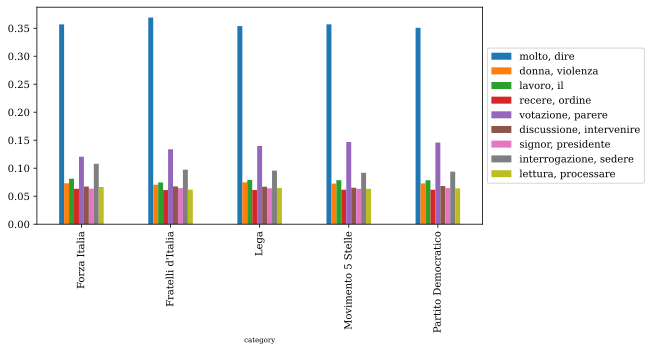

In [23]:
#target_category = 
fig, ax = plt.subplots(figsize=(8, 4)) 

aggregate_by_category = topic_distros[topic_distros.category.isin(('Forza Italia',
 "Fratelli d'Italia",
 'Lega',
 'Movimento 5 Stelle',
 'Partito Democratico'))]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
aggregate_by_category
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax,fontsize=10)
plt.rc('xtick', labelsize=5)
plt.rc('ytick', labelsize=5)

# move the legend out
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5),fontsize=10)
plt.show()

In [24]:
# REQUIRES THE INSTALLATION OF: pyldavis
#NOTE: Running it requires to run the topic model, also the interactive visualisation that results
#from it changes the format of the notebook so better to comment the last line once it has been visualised
#and re run the cell to get back the original notebook formatting and continue to run the following cells.

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from imp import reload
pyLDAvis.enable_notebook()

lda_display = gensimvis.prepare(model, model_corpus,dictionary,sort_topics=False,mds='mmds')

#Uncomment this line to see the visualisation
pyLDAvis.display(lda_display)

###### Legend:
#- Each bubble represents a topic. The larger the bubble, the higher percentage of documents that are about that topic.
#- Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
#- Red bars give the estimated number of times a given term was generated by a given topic. 
#- The further the bubbles are away from each other, the more different they are. 

The LDA model, despite being very useful to get a first idea of what is going on in our corpus in terms of topics, tends to flatten the result toward a uniform distribution because of the aggregagation by category. Despite the trimming of the dstribution relative to the most frequent words, it's still biased as the results greatly vary in the topic of common words for all the categories. In order to overcome such issues we decided to train an author model which helps us have a more realistic specification of the principal topics among the category of our interest.

### Author Topic Model

In [25]:
from gensim.models import AuthorTopicModel,LdaMulticore, TfidfModel, CoherenceModel
from gensim.test.utils import datapath, temporary_file
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 7, 'font.style': 'normal', 'font.family':'serif'})

In [26]:
from collections import defaultdict
author2doc = defaultdict(list) 

target_category = 'Party_name_red'

for i, party in enumerate(df[target_category]):
    author2doc[party].append(i)
    
len(author2doc)

5

In [27]:
corpusaut = df.lemmatized
clean_cpaut = pd.Series(corpusaut)
instancesaut = clean_cpaut.apply(str.split).tolist()
#creating a dictionary of the words based on their frequencies
phrasesaut = Phrases(instancesaut, min_count=5,threshold=1)
collocationsaut = phrasesaut[instancesaut]
dictionaryaut = Dictionary(collocationsaut)
#take out too rare or too frequent words
dictionaryaut.filter_extremes(no_below=10, no_above=0.25)
#I then used gensim to transform the corpus into a TFIDF-weighted matrix
ldacorpusaut = [dictionaryaut.doc2bow(word) for word in instancesaut]

modelaut = TfidfModel(ldacorpusaut)
model_corpusaut = modelaut[ldacorpusaut]

In [28]:
warnings.filterwarnings('ignore')
coherence_values = []
author_model_list = []


dev_author2doc = {key: [idx for idx in value] for key, value in author2doc.items()}

for num_topics in range(3, 20):
    author_model = AuthorTopicModel(corpus=list(ldacorpusaut), 
                                    author2doc=dev_author2doc, 
                                    id2word=dictionaryaut, 
                                    num_topics=num_topics,
                                    alpha=0.9,
                                    eta=0.2,
                                    random_state=45
                                   )
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instancesaut, 
                                          dictionary=dictionaryaut, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instancesaut, 
                                       dictionary=dictionaryaut, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

3 -1.0918614215575468 0.4764440532789653
4 -1.1661616722595018 0.42897220240877426
5 -1.1795342931578277 0.4788377315834424
6 -1.2671825595152217 0.39124245817347525
7 -1.6771179249500803 0.3812684305008342
8 -1.656385018423978 0.36982646908727357
9 -1.5712202999081433 0.4010458299292463


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p17 = _nlv < LooseVersion("1.17")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p18 = _nlv < Loose

10 -1.9471937233713157 0.34132499213004536
11 -2.042237574695069 0.33821967944372106
12 -2.106439240341891 0.34158050750252933
13 -2.1395826223090686 0.33321651717640133
14 -2.648840482564979 0.3448576496557553
15 -2.7005919213896603 0.3693867758197588
16 -2.473992375472392 0.36795602567568714
17 -2.657778806982784 0.3586303733499225
18 -3.0370079344498007 0.35354442977380623
19 -3.3523724460321587 0.3332039225801063


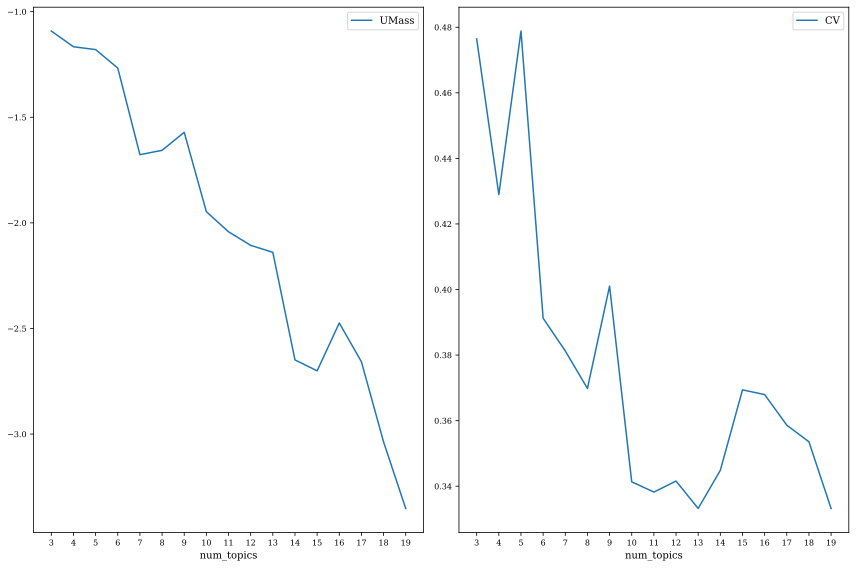

In [29]:
%matplotlib inline
warnings.filterwarnings('ignore')
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(3,20),fontsize=8);
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(3,20),fontsize=8);
fig.tight_layout()



We decided to train the model on  topics, as we register a local minum in the UMASS score and a local maximum in the CV score. 

Parameters:
Alpha: set to 0.9, the reason is that we expect the speeches to be very focused on one single topic, as it usually        happens during parliament sessions
Betha : set to 0.2, as we expect the words not be very specific to topics, parliament language requires indeed some formalism, therefore we expect a repetition of some common words.

In [30]:
n_topics_author = 9

num_passes = 10
chunk_size = len(model_corpusaut) * num_passes/200

start = time.time()
author_model = AuthorTopicModel(corpus=list(ldacorpusaut), 
                                author2doc=author2doc, 
                                id2word=dictionaryaut, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.9,
                                eta = 0.2,
                                random_state=38)
print(f"{time.time()-start}")

62.81705403327942


In [32]:
warnings.filterwarnings('ignore')
topic_sep = re.compile("0\.[0-9]{3}\*") 

author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "dell", "giustiziare", "diritto", "politico", "caso"
2 "settore", "produrre", "ambiente", "culturale", "territorio"
3 "presidente", "molto", "avere", "governo", "dire"
4 "presidente", "signor", "parere", "esprimere", "emendamento"
5 "lavorare", "emergenza", "miliardo", "euro", "impresa"
6 "sedere", "interrogazione", "ora", "senato", "leggere"
7 "scuola", "donna", "mozione", "violenza", "studente"
8 "dell", "leggere", "decretare", "all", "signor"
9 "votazione", "emendamento", "dell", "senato", "presentare"


In [26]:
author_descriptors = ['Law','Economical_terms','Shared_words','Parliament_language','Jobs',
                     'Jurisprudence_language','Social_themes','Parliament_language2','Jurisprudence_language2']
len(author_descriptors)

9

In [27]:
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }
# update mappings from model
for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

In [28]:
from copy import deepcopy
dict_del = deepcopy(author_vecs)
for i,v in dict_del.items():
    for j,k in v.items():
        if j =='Shared_words' or j=='Jurisprudence_language':
            del author_vecs[i][j]

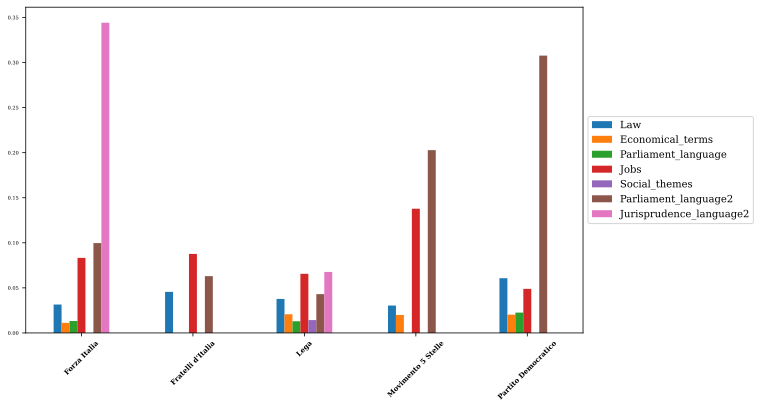

In [29]:
author_df = pd.DataFrame.from_dict(author_vecs)
target_category = ['Forza Italia',
 "Fratelli d'Italia",
 'Lega',
 'Movimento 5 Stelle',
 'Partito Democratico']
# plot it
fig, ax = plt.subplots(figsize=(10,6))
author_df[target_category].T.plot.bar(ax=ax)
plt.xticks(weight='bold',fontsize = 7,rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

As expected the dominant topics are the one formed by the jurisprudence language,and the more general cluster
'parliament language', as the parliament speakers need to maintain a great formalism during their speeches. However, the author model yields a less uniform distribution with respect to the remaining topics. Indeed, it is interesting to notice also the high prevalence of the 'job' topic amongst all the parties. This refelcts the concern for jobs policies that has been long standing in italian politics, and which the COVID 19 pandemic only accentuated, thus also being reflectd in this data since it also follows the pandemic period. 

## Conclusion



Indeed as it iis possible to see form the heterogeneity in topic distribution, the presence of clusters through doc2vec (albeit the clusters being quite close) and the particularity of political language highlighted by word2vec, it is indeed possible to establish the presence of a certain variety amongst ways that parliamentaries form different parties speak and the topics that they speak about. This motivates the creation and need for specific tools that can exploit well the nuances and particularieties of differences in italian parliamentary language to aid social scientists.